In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [71]:
# %%
# Load the CDD data
cdd_file = "cddid.tbl.gz"
cdd_df = pd.read_csv(cdd_file, sep="\t", header=None, names=["CDD_ID", "Domain_ID", "Gene_Name", "Description", "Length"])
cdd_df = cdd_df[["Domain_ID","Gene_Name"]]
# View first few rows
print(cdd_df)

        Domain_ID     Gene_Name
0        CHL00001          rpoB
1        CHL00002          matK
2        CHL00003          psbA
3        CHL00004          psbD
4        CHL00005         rps16
...           ...           ...
67155  smart01100   CRAL_TRIO_N
67156  smart01101  CRISPR_assoc
67157  smart01102        CRM1_C
67158  smart01103     CRS1_YhbY
67159  smart01104           CTD

[67160 rows x 2 columns]


In [72]:
superfam_df = pd.read_csv("CDDID_SuperfamilyID.txt", sep='\t')
superfam_df.columns = ["CDD_ID_1", "Accession_1", "CDD_ID_2", "Accession_2"]

superfam_df = superfam_df.drop(columns=[ "Accession_1","Accession_2" ])
# Rename columns for clarity
superfam_df.columns = ["CDD_ID", "Superfamily"]

# Drop duplicates if any
superfam_df = superfam_df.drop_duplicates()
#superfam_df

In [73]:

RNA_seq_df = pd.read_csv("amphimedon_rnaseq.txt", sep='\t')
#RNA_seq_df.head(1)

In [74]:
setsub_seq_df = pd.read_csv("SETSubfamilies.txt", sep='\t')

setsub_seq_df[['CDD_ID','Gene_ID']] =setsub_seq_df["CDD_ID  Gene_ID"].str.split(r"\s+", n=1, expand=True)
setsub_seq_df = setsub_seq_df.drop(columns=["CDD_ID  Gene_ID"])
print(setsub_seq_df.columns)
setsub_seq_df

Index(['CDD_ID', 'Gene_ID'], dtype='object')


,CDD_ID,Gene_ID
0,cd10518,SET_SETD1-like
1,cd10519,SET_EZH
2,cd10522,SET_LegAS4-like
3,cd10524,SET_Suv4-20-like
4,cd10527,SET_LSMT
5,cd10528,SET_SETD8
6,cd10529,SET_SETD5-like
7,cd10530,SET_SETD7
8,cd10531,SET_SETD2-like
9,cd10534,PR-SET_PRDM-like


In [75]:
cddid_df = pd.read_csv("mart_export (2).txt", sep='/t')
cddid_df[['Gene_ID', 'CDD_ID']] = cddid_df["Gene stable ID	CDD ID"].str.split("\t", expand=True)
# Drop the old combined column
cddid_df = cddid_df.drop(columns=["Gene stable ID	CDD ID"])
#cddid_df

C:\Users\ssali\AppData\Local\Temp\ipykernel_21024\3647494203.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cddid_df = pd.read_csv("mart_export (2).txt", sep='/t')


In [76]:
merged_df = cddid_df.merge(superfam_df, on='CDD_ID')
df_merged = merged_df.merge(cdd_df, left_on="Superfamily", right_on="Domain_ID", how="left")

# Append gene names directly to the Superfamily column
df_merged["Superfamily"] = df_merged["Superfamily"] + ": " + df_merged["Gene_Name"]

df_merged.drop(columns=["Domain_ID"], inplace=True)
merged_df=df_merged
df_merged

,Gene_ID,CDD_ID,Superfamily,Gene_Name
0,LOC100631963,cd04458,cl09927: S1_like,S1_like
1,LOC100631963,cd04458,cl09927: S1_like,S1_like
2,LOC105316874,cd16620,cl17238: RING_Ubox,RING_Ubox
3,LOC100637711,cd02809,cl21457: TIM,TIM
4,LOC109584330,cd01670,cl14633: DD,DD
...,...,...,...,...
10867,LOC105313484,cd15863,cl22856: SNARE,SNARE
10868,LOC109583428,cd00096,cl11960: Ig,Ig
10869,LOC109583428,cd00096,cl11960: Ig,Ig
10870,LOC100640765,cd00472,cl00909: Ribosomal_L24e_L24,Ribosomal_L24e_L24


In [77]:
final_df = merged_df.merge(RNA_seq_df, left_on="Gene_ID", right_on="GeneID", how="inner")
final_df["CDD_ID"]
finals_df = final_df.merge(setsub_seq_df,on= "CDD_ID",how="inner")
finals_df

,Gene_ID_x,CDD_ID,Superfamily,Gene_Name,GeneID,TranscriptID,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae,Gene_ID_y
0,LOC105313876,cd10529,cl40432: SET,SET,LOC105313876,XM_020000342.1,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778,SET_SETD5-like
1,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SET_SETD9
2,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_019997323.1,6.581,0.677,1.631,0.899,1.911,1.145,2.074,4.535,SET_SETD9
3,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XR_002185158.1,0.269,1.046,1.294,0.740,0.091,0.631,1.030,0.248,SET_SETD9
4,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SET_SETD9
5,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_019997323.1,6.581,0.677,1.631,0.899,1.911,1.145,2.074,4.535,SET_SETD9
6,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XR_002185158.1,0.269,1.046,1.294,0.740,0.091,0.631,1.030,0.248,SET_SETD9
7,LOC100639445,cd10528,cl40432: SET,SET,LOC100639445,XM_003387084.3,3.977,12.175,30.376,13.543,8.059,3.072,2.193,5.826,SET_SETD8
8,LOC105311972,cd10530,cl40432: SET,SET,LOC105311972,XM_011404238.2,5.983,12.001,5.386,5.458,2.763,4.355,8.580,13.334,SET_SETD7


In [78]:
#Drop unnecessary columns
Superfamily_Transcript_df =  finals_df.drop(columns=['GeneID','CDD_ID','Superfamily','Gene_ID_x'])

#print(Superfamily_Transcript_df)

#Keep all unique superfamily-transcript ID combinations
df_unique = Superfamily_Transcript_df.drop_duplicates(subset=["Gene_ID_y", "TranscriptID"])
#df_unique.drop(columns=["TranscriptID"], inplace=True)
#print(df_unique)

# Sum TPM across all rows with the same Superfamily
#df_summed = df_unique.groupby("Superfamily").sum(numeric_only=True).reset_index()
df_summed = df_unique.groupby("Gene_ID_y").agg({
    "Gene_Name": "first",  # Keeps one representative Gene_Name per Superfamily
    **{col: "sum" for col in df_unique.columns if col not in ["Gene_ID_y", "Gene_Name"]}
}).reset_index()
print(df_summed) 

#print(df_summed)

numeric_cols = df_summed.columns[3:]  # Select only numerical columns
#df_loged = df_summed[numeric_cols]
df_loged = np.log2(df_summed[numeric_cols].replace(0, 0.5) + 0.5)
df_loged["Gene_ID_y"] = df_summed["Gene_ID_y"]
df_loged["Gene_Name"] = df_summed["Gene_Name"]
df_loged = df_loged.sort_values(by="Gene_Name", ascending=True)
df_loged.drop(columns=["Gene_Name"] ,inplace= True)


df_loged


        Gene_ID_y Gene_Name                                TranscriptID  \
0  SET_SETD5-like       SET                              XM_020000342.1   
1       SET_SETD7       SET                              XM_011404238.2   
2       SET_SETD8       SET                              XM_003387084.3   
3       SET_SETD9       SET  XM_003386971.3XM_019997323.1XR_002185158.1   

   Sample.Cleavage  Sample.Brown  Sample.Cloud  Sample.Spot  Sample.Late.spot  \
0           67.503        69.147        46.762       35.163            38.088   
1            5.983        12.001         5.386        5.458             2.763   
2            3.977        12.175        30.376       13.543             8.059   
3           27.166        21.343         8.657        8.719             6.009   

   Sample.Ring  Sample.Late.ring  Sample.Free.swimming.larvae  
0       22.514            87.295                       92.778  
1        4.355             8.580                       13.334  
2        3.072            

,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae,Gene_ID_y
0,6.087526,6.121989,5.562609,5.156356,5.270080,4.524440,6.456067,6.543465,SET_SETD5-like
1,2.696662,3.643972,2.557288,2.574828,1.706199,2.279471,3.182692,3.790146,SET_SETD7
2,2.162532,3.663914,4.948414,3.811779,3.097442,1.836732,1.429214,2.661294,SET_SETD8
3,4.790042,4.449099,3.194875,3.204610,2.702436,2.652372,3.496718,5.022412,SET_SETD9


In [79]:
output_file = 'unique_TPM_expression_amph.txt'
df_loged.to_csv(output_file, sep='\t', index=False)
df_loged

,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae,Gene_ID_y
0,6.087526,6.121989,5.562609,5.156356,5.270080,4.524440,6.456067,6.543465,SET_SETD5-like
1,2.696662,3.643972,2.557288,2.574828,1.706199,2.279471,3.182692,3.790146,SET_SETD7
2,2.162532,3.663914,4.948414,3.811779,3.097442,1.836732,1.429214,2.661294,SET_SETD8
3,4.790042,4.449099,3.194875,3.204610,2.702436,2.652372,3.496718,5.022412,SET_SETD9


In [80]:
df_heat = df_summed.loc[:, df_summed.columns.str.startswith("Sample")]

df_heat.head()

,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae
0,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778
1,5.983,12.001,5.386,5.458,2.763,4.355,8.580,13.334
2,3.977,12.175,30.376,13.543,8.059,3.072,2.193,5.826
3,27.166,21.343,8.657,8.719,6.009,5.787,10.788,32.001


In [81]:
row_mean = df_heat.mean(axis=1)
log_mean = np.log2(row_mean)
log_mean

0    5.843136
1    2.854494
2    3.307811
3    3.912530
dtype: float64

In [82]:
numeric_cols = df_heat.select_dtypes(include='number')
df_centered = numeric_cols.sub(log_mean, axis=0)
df_centered.head()

,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae
0,61.659864,63.303864,40.918864,29.319864,32.244864,16.670864,81.451864,86.934864
1,3.128506,9.146506,2.531506,2.603506,-0.091494,1.500506,5.725506,10.479506
2,0.669189,8.867189,27.068189,10.235189,4.751189,-0.235811,-1.114811,2.518189
3,23.253470,17.430470,4.744470,4.806470,2.096470,1.874470,6.875470,28.088470


In [83]:
max_value = df_centered.max().max()

min_value = df_centered.min().min()

print("Max value:", max_value)
print("Min value:", min_value)

Max value: 86.93486408888866
Min value: -1.114811007262631


In [90]:
finals_df

,Gene_ID_x,CDD_ID,Superfamily,Gene_Name,GeneID,TranscriptID,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae,Gene_ID_y
0,LOC105313876,cd10529,cl40432: SET,SET,LOC105313876,XM_020000342.1,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778,SET_SETD5-like
1,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SET_SETD9
2,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_019997323.1,6.581,0.677,1.631,0.899,1.911,1.145,2.074,4.535,SET_SETD9
3,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XR_002185158.1,0.269,1.046,1.294,0.740,0.091,0.631,1.030,0.248,SET_SETD9
4,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_003386971.3,20.316,19.620,5.732,7.080,4.007,4.011,7.684,27.218,SET_SETD9
5,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XM_019997323.1,6.581,0.677,1.631,0.899,1.911,1.145,2.074,4.535,SET_SETD9
6,LOC100635065,cd10537,cl40432: SET,SET,LOC100635065,XR_002185158.1,0.269,1.046,1.294,0.740,0.091,0.631,1.030,0.248,SET_SETD9
7,LOC100639445,cd10528,cl40432: SET,SET,LOC100639445,XM_003387084.3,3.977,12.175,30.376,13.543,8.059,3.072,2.193,5.826,SET_SETD8
8,LOC105311972,cd10530,cl40432: SET,SET,LOC105311972,XM_011404238.2,5.983,12.001,5.386,5.458,2.763,4.355,8.580,13.334,SET_SETD7


In [91]:
df_summed


,Gene_ID_y,Gene_Name,TranscriptID,Sample.Cleavage,Sample.Brown,Sample.Cloud,Sample.Spot,Sample.Late.spot,Sample.Ring,Sample.Late.ring,Sample.Free.swimming.larvae,Max_Fold_Change
0,SET_SETD5-like,SET,XM_020000342.1,67.503,69.147,46.762,35.163,38.088,22.514,87.295,92.778,4.031372
1,SET_SETD7,SET,XM_011404238.2,5.983,12.001,5.386,5.458,2.763,4.355,8.580,13.334,4.086424
2,SET_SETD8,SET,XM_003387084.3,3.977,12.175,30.376,13.543,8.059,3.072,2.193,5.826,11.279614
3,SET_SETD9,SET,XM_003386971.3XM_019997323.1XR_002185158.1,27.166,21.343,8.657,8.719,6.009,5.787,10.788,32.001,5.090027


In [84]:
import matplotlib.colors as mcolors

C:\Users\ssali\AppData\Local\Temp\ipykernel_21024\3274543576.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Fig. project 1 part 2.The superfamily domains have been transformed to log2 TPM values.\nTheir prevalence is centered on the row mean.",


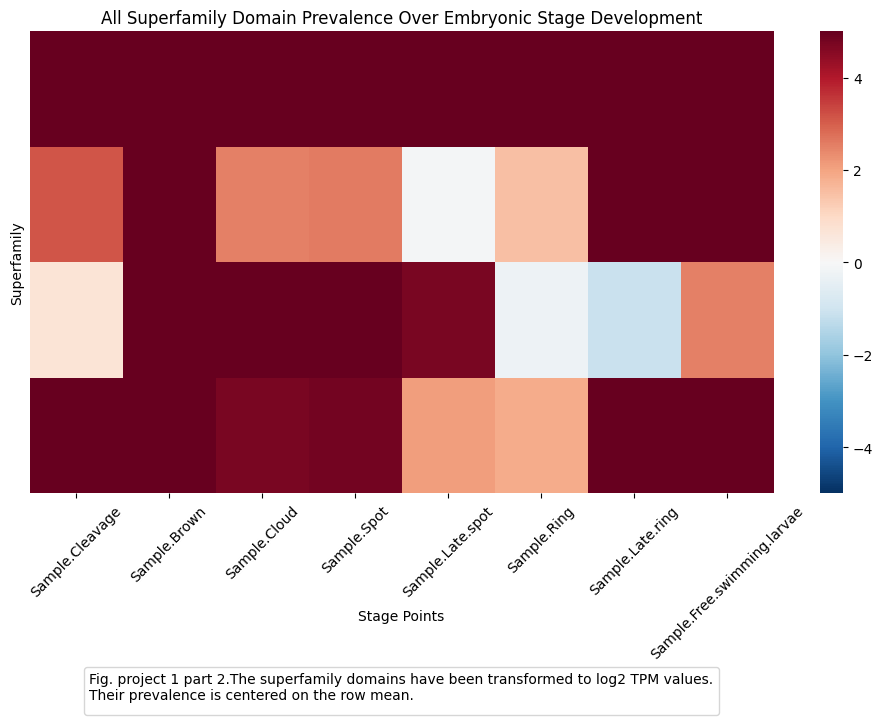

In [85]:
plt.figure(figsize=(12, 6))
normalize = mcolors.TwoSlopeNorm(vcenter=0, vmin=-5, vmax=5)
ax = plt.gca()

sns.heatmap(df_centered, cmap="RdBu_r", norm = normalize)
plt.xlabel("Stage Points")
ax.xaxis.set_label_coords(0.5, -0.25)
plt.ylabel("Superfamily")
plt.title("All Superfamily Domain Prevalence Over Embryonic Stage Development")
plt.xticks(rotation=45)
plt.legend(title="Fig. project 1 part 2.The superfamily domains have been transformed to log2 TPM values.\nTheir prevalence is centered on the row mean.",
           loc='upper center',
           bbox_to_anchor=(0.5, -0.36),
           ncol = 20)
plt.yticks([])
plt.show()

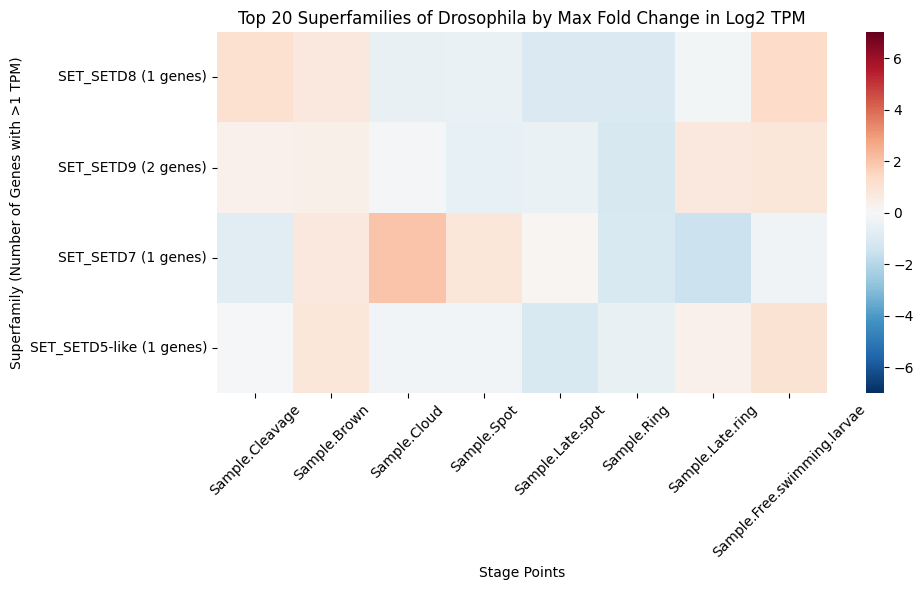

<Figure size 640x480 with 0 Axes>

In [93]:
tpm_columns = [col for col in df_summed.columns if col.startswith('Sample.')]
df_summed['Max_Fold_Change'] = df_summed[tpm_columns].max(axis=1) / (df_summed[tpm_columns].min(axis=1) + 0.5)

#sort based on df_summed["Max_Fold_Change"]
df_sortMX = df_summed.sort_values(by='Max_Fold_Change', ascending=False)

gene_counts = finals_df[finals_df[tpm_columns].gt(1).all(axis=1)].groupby('Gene_ID_y').size().reset_index(name='Gene_Count')
gene_counts = gene_counts[gene_counts['Gene_Count'] > 0]
#merge gene counts
df_summed_W_genecount = df_sortMX.merge(gene_counts, on='Gene_ID_y', how='left')
#drop na
df_summed_W_genecount = df_summed_W_genecount.dropna(subset=['Gene_Count']) 


top_20_superfamilies = df_summed_W_genecount.head(20)

heatmap_data = top_20_superfamilies.set_index('Gene_ID_y')[tpm_columns]

heatmap_data_log2 = np.log2(heatmap_data + 0.5)

row_mean = heatmap_data_log2.mean(axis=1)
heatmap_data_centered = heatmap_data_log2.sub(row_mean, axis=0)

heatmap_data_centered["log2_diff"] = heatmap_data_log2["Sample.Cleavage"] - heatmap_data_log2["Sample.Free.swimming.larvae"]
heatmap_data_sorted = heatmap_data_centered.sort_values(by="log2_diff", ascending=False)
heatmap_data_sorted = heatmap_data_sorted.drop("log2_diff", axis=1)

row_labels = [f"{superfamily} ({count} genes)" for superfamily, count in zip(top_20_superfamilies['Gene_ID_y'], top_20_superfamilies['Gene_Count'])]

# Plot the smaller heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data_sorted,
    cmap="RdBu_r",
    yticklabels=row_labels,
    vmin=-7,
    vmax=7,
)
plt.title('Top 20 Superfamilies of Drosophila by Max Fold Change in Log2 TPM')
plt.xlabel('Stage Points')
plt.ylabel('Superfamily (Number of Genes with >1 TPM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.draw()
plt.show()
plt.savefig('Top Domains Heatmap- drosophila.pdf')



